# Fermi-Lat

In [3]:
%matplotlib inline

from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from astropy.time import Time
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
import glob 
import sys
#import pandas as pd
import csv
import pandas as pd
from astropy.stats import bayesian_blocks
import astropy
print("astropy version {}".format(astropy.__version__))

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 18, 'figure.figsize': (14.0, 8.0)})
from scipy import stats


def MET2MJD(met):
    mjd_ref = 51910.#+7.428e-4
    return met*1./86400.+mjd_ref
def MJD2MET(mjd):
    mjd_ref = 51910.#+7.428e-4
    met = (mjed - mjd_ref)*86400
    return met

def get_bb_binned_v2(ts, fs, dfs, p0=0.0013, fitness='measures'):
    t_bb_slice = bayesian_blocks(ts, x=fs, 
                                 sigma=dfs, p0=p0, fitness=fitness) #, gamma=1.0)
    c_bb_slice = []
    dc_bb_slice = []

    for i in range(len(t_bb_slice)-1):
        #print(np.where((ts>=t_bb_slice[i]) & (ts<t_bb_slice[i+1])))
        #print(np.mean(fs[np.where((ts>=t_bb_slice[i]) & (ts<t_bb_slice[i+1]))]))
        slice_ind = np.where((ts>=t_bb_slice[i]) & (ts<t_bb_slice[i+1]))
        weighted_avg = np.average(fs[slice_ind], weights=1./dfs[slice_ind])
        c_bb_slice.append( weighted_avg )
        dc_bb_slice.append( np.sqrt(np.average((fs[slice_ind]-weighted_avg)**2, weights=1./dfs[slice_ind])) )
        
    c_bb_slice=np.asarray(c_bb_slice)
    dc_bb_slice=np.asarray(dc_bb_slice)
    return t_bb_slice, c_bb_slice, dc_bb_slice


def bayesian_block(file, y, ax=None, p0=2.7e-3, figsize=(12,5), 
                   fontsize=18, ticksize=14, showUT=True, UTfontsize=18, 
                   label="",
                   scale=1.0, xlabel='Time [MJD]', ylabel=r"Flux [ph cm$^{-2}$ s$^{-1}$]", outfile = ""):
    c = np.load(file, allow_pickle=True, encoding='latin1').item()
    good = np.array([ts > 0 if ~np.isnan(ts) else False for ts in c['ts']])
    #print(good, sum(good))
    good = good * np.array([sigma_>0 for sigma_ in c['flux_err']])
    #print(good, sum(good))
    time = (c['tmin'] + c['tmax']) / 2
    print("Total bins: {}".format(len(time)))
    time = time[good]
    MJD = MET2MJD(time)
    print("Significant bins: {}".format(len(MJD)))
    flux = c['flux'][good]*scale
    sigma = c['flux_err'][good]*scale

    # Calculate the Bayesian blocks
    block_edges = bayesian_blocks(MJD, x=flux, sigma=sigma, fitness='measures', p0=p0) #3sigma
    block_fluxes, __, __ = stats.binned_statistic(MJD, flux, statistic='mean', bins=block_edges)
    block_std, __, __ = stats.binned_statistic(MJD, flux, statistic='std', bins=block_edges)
    
    t_bb_, c_bb_, dc_bb_ = get_bb_binned_v2(MJD, flux, sigma, fitness='measures', p0=p0)

    if ax is None: 
        fig, ax = plt.subplots(figsize=figsize)
    ax.errorbar(MJD, flux, yerr=sigma, marker='o', linestyle='none', label=label, capsize=0)
    ax.plot(block_edges, np.append(block_fluxes, 0), drawstyle='steps-post', color='k', zorder=99)
    ax.fill_between(block_edges,  np.append(block_fluxes+block_std, 0),  np.append(block_fluxes-block_std, 0),
                    where=None, interpolate=False, step='post', color='k', zorder=98, alpha=0.2)

    #ax.plot(t_bb_, np.append(c_bb_, 0), drawstyle='steps-post', color='r', zorder=99)
    #ax.fill_between(t_bb_,  np.append(c_bb_+dc_bb_, 0),  np.append(c_bb_-dc_bb_, 0),
    #                where=None, interpolate=False, step='post', color='r', zorder=98, alpha=0.2)

    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.tick_params(labelsize=ticksize)
    ax.set_xlim(54600, 59500)
    # ax.ticklabel_format(style='sci', scilimits=(-8,-8), axis='y')
    
    if showUT: 
            add_UT_top(ax, fontsize=UTfontsize, ticksize=UTfontsize, xlabel="")

    

    ax.set_title(y, fontsize=UTfontsize)
    
    print(block_edges, block_fluxes)

    plt.savefig(outfile)
    #plt.show()
    return ax, block_edges, block_fluxes, block_std    
    
def add_UT_top(ax, MJD_offset=0, t_unit_days=1, rotation=0, fontsize=14, ticksize=12,
               date_format="%Y-%m-%d", xlabel=r"UT date"):
    ax1_top = ax.twiny()
    tick_dates = [ label_*t_unit_days+MJD_offset for label_ in ax.xaxis.get_ticklocs() ]
    ax1_top.set_xlim(ax.get_xlim())
    UT_dates_label = [ (Time(mjd_, format='mjd')).datetime.strftime(date_format) for mjd_ in tick_dates ]
    ax1_top.set_xticklabels(UT_dates_label, rotation=rotation)
    ax1_top.set_xlabel(xlabel, fontsize=fontsize)
    ax1_top.tick_params(labelsize=ticksize)    

def read_LAT_LC(file):
    c = np.load(file, allow_pickle=True, encoding='latin1').item()
    good = np.array([ts > 0 if ~np.isnan(ts) else False for ts in c['ts']])
    time = (c['tmin'] + c['tmax']) / 2
    print("Total bins: {}".format(len(time)))
    time = time[good]
    MJD = MET2MJD(time)
    print("Significant bins: {}".format(len(MJD)))
    flux = c['flux'][good]
    sigma = c['flux_err'][good]
    return MJD, flux, sigma

def read_VEGAS_LC(file):
    df = pd.read_csv(f, sep = r"\s+",  header=None, names=['mjd','f','df','lt'], encoding = 'unicode_escape')
    df = df[df['lt']>0]
    #added next line to exclude fluxes < 0
    df = df[df['f']>0]
    df['f'] = df['f']/1e4
    df['df'] = df['df']/1e4
    df['dmjd']=df['lt']/86400.
    return df['dmjd'], df['f'], df['df']

astropy version 2.0.16


Total bins: 146
Significant bins: 99
Total bins: 146
Significant bins: 99


(array([54727.65530093, 59017.65530093]), array([0.02621674]))


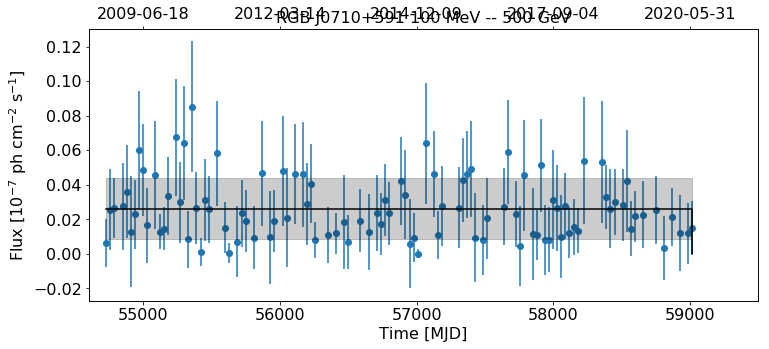

In [4]:
sname = "RGB J0710+591"
sprefix = "RGBJ0710"
f = "FermiLCs/{}_lightcurve_combined.npy".format(sprefix)
file = "../{}/stage6/2_5_8/lightcurve_daily.dat".format(sprefix)
of_file = "results/Fermi{}.png".format(sprefix)
t_, f_, df_ = read_LAT_LC(f)
# tv_, fv_, dfv_ = read_VEGAS_LC(file)

ax_0, block_edges, block_fluxes, block_std = bayesian_block(f, '{} 100 MeV -- 500 GeV'.format(sname),
                    UTfontsize=16, p0=5.7e-7, fontsize=16, ticksize=16,
                    scale=1e7, ylabel=r"Flux [$10^{-7}$ ph cm$^{-2}$ s$^{-1}$]", outfile = of_file) #σ
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# ax.text(0.85, 0.95, "{} blocks".format(len(block_fluxes)), transform=ax.transAxes, fontsize=14,
#         verticalalignment='top', bbox=props)

# plt.tight_layout()
#plt.savefig("{}_2020_LAT.pdf".format(sname))

# VERITAS 

In [17]:
def getBB_source_VERITAS(f, plot_unit = 1e-10, package="VEGAS", p0=3e-7, 
                 outfile="1ES1215_LAT_BayesianBlock_5sigma.pdf", zoomdates=None): 
    if package in ["ED","ed","E","EventDisplay","eventdisplay", "eventdisp"]:
        df = pd.read_csv(f, 
                   sep=r"\s+", 
                   names=['mjd', 'dmjd', 'f', 'df'])
    elif package in["VEGAS","Vegas","vegas","V"]: 
        df = pd.read_csv(f, sep = r"\s+",  header=None, 
                    names=['mjd','f','df','lt'])
        df = df[df['lt']>0]
        df = df[df['f']>0]
        df['f'] = df['f']/1e4
        df['df'] = df['df']/1e4
        df['dmjd']=df['lt']/86400.
    else:
        print("Illegal package provided")
        return None


    fig = plt.figure(figsize=(10, 4))
    fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
    ax = fig.add_subplot(111)

    t_bb, c_bb, dc_bb = get_bb_binned_v2(df.mjd.values, df.f.values, df.df.values,
                                                #p0=3e-1, fitness='measures')
                                                p0=p0, fitness='measures')

#     display(df)
    ax.errorbar(df.mjd, df.f.values/plot_unit, xerr=df.dmjd.values, yerr=df.df.values/plot_unit, 
                fmt='o', color='k', ecolor='k', mec='k', ms=4, capthick=0, alpha=0.8, label="VERITAS nightly")

    ax.bar((t_bb[:-1]), c_bb/plot_unit, width=np.diff(t_bb), align="edge",
           alpha=0.3, color='b', label = r"Bayesian Blocks (5-$\sigma$)")


    ax.legend(prop=dict(size=12))
    ax.set_xlabel('t [MJD]', fontsize=14)
    ax.set_ylabel(r'Flux > 200 GeV'+'\n'+r'(10$^{-10}$ ph cm$^{-2}$ s$^{-1}$)', color='k', fontsize=14)
    if zoomdates is not None: 
        ax.set_xlim(zoomdates)
    ax.set_xlim(59100, 59500)
#     ax.set_ylim(0, 1)

    add_UT_top(ax, MJD_offset=0, t_unit_days=1., xlabel=r"UT date") #date_format="%m-%d", 


#     plt.savefig(outfile)
#     #plt.savefig("1ES1215_LAT_BayesianBlock_5sigma_zoomout.pdf")


#     plt.show()
    return t_bb, c_bb, dc_bb
#     return df, t_bb, c_bb

In [16]:
fig, axs = plt.subplots(2)
fig.suptitle('1ES 1727+502')


#VERITAS
source = "1ES1727"
ofile = "results/VEGAS{}.png".format(source)
file_VERITAS = "../{}/stage6/2_5_8/lightcurve_daily.dat".format(source)
t_bb, c_bb, dc_bb = getBB_source_VERITAS(file_VERITAS, outfile = ofile)

plot_unit = 1e-10

df = pd.read_csv(file_VERITAS, sep = r"\s+",  header=None, names=['mjd','f','df','lt'])
df = df[df['lt']>0]
df = df[df['f']>0]
df['f'] = df['f']/1e4
df['df'] = df['df']/1e4
df['dmjd']=df['lt']/86400.


axs[0].bar((t_bb[:-1]), c_bb/plot_unit, width=np.diff(t_bb), align="edge",
           alpha=0.3, color='b', label = r"Bayesian Blocks")
axs[0].errorbar(df.mjd, df.f.values/plot_unit, xerr=df.dmjd.values, yerr=df.df.values/plot_unit, 
                fmt='o', color='k', ecolor='k', mec='k', ms=4, capthick=0, alpha=0.8, label="VERITAS")
print(f"VERITAS block edges: {t_bb[:-1]}")
print(c_bb/plot_unit)

#Fermi-LAT
scale=1e7
label= ""
sname = "1ES 1727+502"
sprefix = "1ES1727"
f = "FermiLCs/{}_lightcurve_combined.npy".format(sprefix)
file = "../{}/stage6/2_5_8/lightcurve_daily.dat".format(sprefix)
of_file = "results/Fermi{}.png".format(sprefix)
t_, f_, df_ = read_LAT_LC(f)
# tv_, fv_, dfv_ = read_VEGAS_LC(file)
c = np.load(f, allow_pickle=True, encoding='latin1').item()
good = np.array([ts > 0 if ~np.isnan(ts) else False for ts in c['ts']])
good = good * np.array([sigma_>0 for sigma_ in c['flux_err']])
time = (c['tmin'] + c['tmax']) / 2
print("Total bins: {}".format(len(time)))
time = time[good]
MJD = MET2MJD(time)
print("Significant bins: {}".format(len(MJD)))
flux = c['flux'][good]*scale
sigma = c['flux_err'][good]*scale
print(f"sgima = {sigma}")
ax, block_edges, block_fluxes, block_std = bayesian_block(f, '{} 100 MeV -- 500 GeV'.format(sname),
                    UTfontsize=16, p0=5.7e-7, fontsize=16, ticksize=16,
                    scale=1e7, ylabel=r"Flux [$10^{-7}$ ph cm$^{-2}$ s$^{-1}$]", outfile = of_file)
print(f"bloack edges: {block_edges[:-1]}")
print(np.append(block_fluxes, 0))
axs[1].bar((block_edges[:-1]), block_fluxes, width=np.diff(block_edges), align="edge",
           alpha=0.3, color='b', label = r"Bayesian Blocks")
axs[1].errorbar(MJD, flux, yerr=sigma, marker='o', color = 'k',linestyle='none', label="Fermi-LAT", capsize=0)

axs[1].set_xlim(54600, 59500)
# axs[1].set_ylim(-0.02, 0.12)
axs[0].set_xlim(54600, 59500)
# axs[1].bar((block_edges[:-1]), np.append(block_fluxes, 0), drawstyle='steps-post', color='k', zorder=99)
# axs[1].fill_between(block_edges,  np.append(block_fluxes+block_std, 0),  np.append(block_fluxes-block_std, 0),
#                     where=None, interpolate=False, step='post', color='k', zorder=98, alpha=0.2)
# axs[1].plot(x, -y)

axs[0].legend(loc="upper right")
axs[1].legend(loc="upper right")
fig.text(0.5, 0.04, 't [MJD]', ha='center', va='center')
fig.text(0.06, 0.5, r'Flux [10^(-7) ph cm^(-2) s^(-1)', ha='center', va='center', rotation='vertical')
plt.show()
print(f"numpy diff {c}")

SyntaxError: invalid syntax (<ipython-input-16-9f6b5c83f2f6>, line 25)

,mjd,f,df,lt,dmjd
0,59116.28022,2.076957e-10,1.581519e-10,1583.7920,0.018331
14,59130.28022,3.108477e-11,3.886829e-11,3246.4620,0.037575
15,59131.28022,2.713585e-11,1.105835e-10,786.2276,0.009100
16,59132.28022,2.713983e-11,5.406654e-11,779.6942,0.009024
17,59133.28022,1.104381e-10,1.676606e-10,788.0413,0.009121
19,59135.28022,1.548635e-11,5.764747e-11,792.9871,0.009178
20,59136.28022,4.399199e-11,1.215595e-10,787.7201,0.009117
23,59139.28022,9.244268e-10,9.091856e-10,792.4772,0.009172
24,59140.28022,4.623064e-09,4.685618e-09,786.5857,0.009104
370,59486.28022,3.309644e-10,3.207104e-10,3149.2490,0.036450


<Container object of 3 artists>

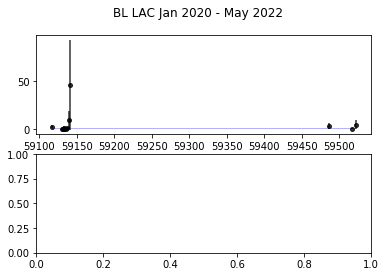

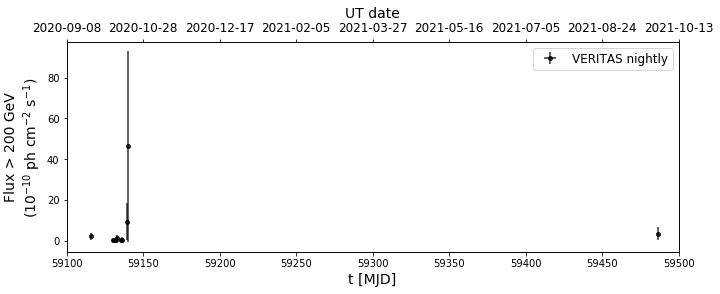

In [18]:
fig, axs = plt.subplots(2)
fig.suptitle('BL LAC Jan 2020 - May 2022')


#VERITAS
source = "BL_LAC_2020"
ofile = "results/VEGAS{}.png".format(source)
file_VERITAS = "../{}/stage6/2_5_8/lightcurve.dat".format(source)
t_bb, c_bb, dc_bb = getBB_source_VERITAS(file_VERITAS, outfile = ofile)

plot_unit = 1e-10

df = pd.read_csv(file_VERITAS, sep = r"\s+",  header=None, names=['mjd','f','df','lt'])
df = df[df['lt']>0]
df = df[df['f']>0]
df['f'] = df['f']/1e4
df['df'] = df['df']/1e4
df['dmjd']=df['lt']/86400.


axs[0].bar((t_bb[:-1]), c_bb/plot_unit, width=np.diff(t_bb), align="edge",
           alpha=0.3, color='b', label = r"Bayesian Blocks")
axs[0].errorbar(df.mjd, df.f.values/plot_unit, xerr=df.dmjd.values, yerr=df.df.values/plot_unit, 
                fmt='o', color='k', ecolor='k', mec='k', ms=4, capthick=0, alpha=0.8, label="VERITAS")
